In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import swyft
import pickle

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = np.load("../data/resampling_data_with_signal/cg_data_3QLQSJ.npy")

In [9]:
import sys
import saqqara
sys.path.insert(0, "../simulator")
from simulator import LISA_AET
config = "../configs/bounded_resampling_config.yaml"
settings = saqqara.load_settings(config)
sim = LISA_AET(settings=settings)

Detector setup complete
Noise matrices computed
Response computed
Coarse graining setup complete


In [29]:
np.sum(data[0], axis=0).shape

(945, 3)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


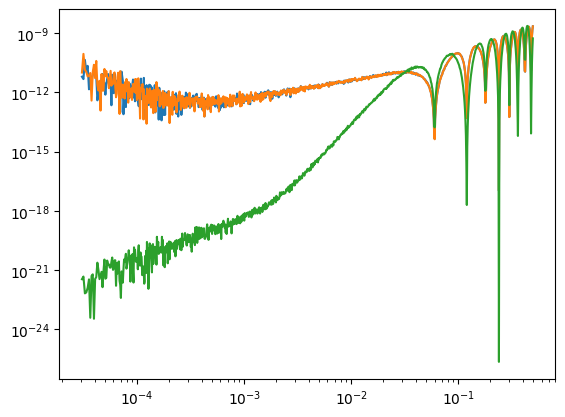

In [31]:
plt.loglog(sim.coarse_grained_f, np.sum(data[0], axis=0) * sim.cg_response_AET)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


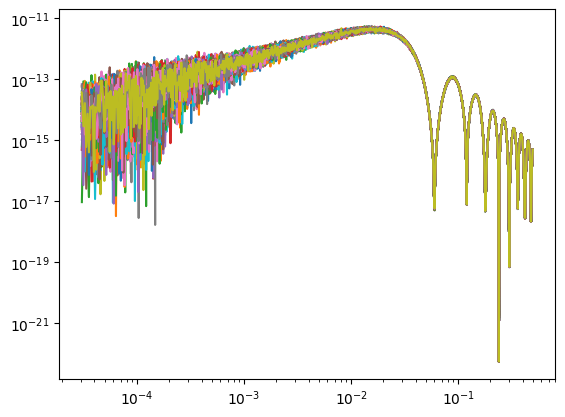

In [23]:
sig_data = sim.generate_coarse_grained_data_from_sum(sim.generate_quadratic_signal_data(z=np.array([-11.0, 0.0, 3.0, 15.0])))
plt.loglog(sim.coarse_grained_f, sig_data[:, 0] * sim.cg_response_AET[:, 0])
plt.loglog(sim.coarse_grained_f, np.einsum("ij,i->ij", data[:, 2, :, 0].T, sim.cg_response_AET[:, 0]))

In [2]:
id = "G7RG" # "DZ66" # "OO2F" # "UD3J" # "57LN"
lr_result_files = glob.glob(f"../results/resampling_logratios_{id}/logratios*.pkl")
flr_result_files = glob.glob(f"../results/resampling_logratios_{id}/fixed_logratios*.pkl")

In [3]:
len(lr_result_files)
#len(flr_result_files)

1045

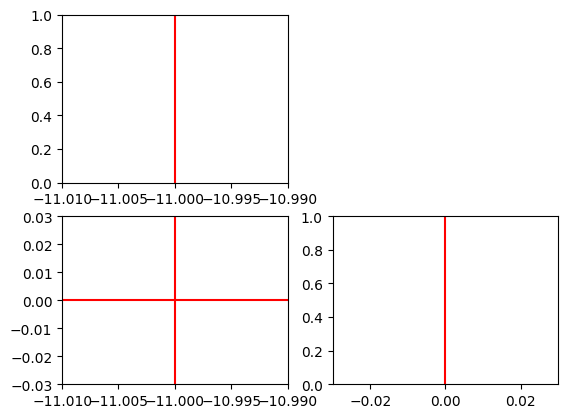

In [6]:
for idx, lr_file in enumerate(lr_result_files[::986]):
    logratios = pickle.load(open(lr_file, "rb"))
    pickle.dump(logratios, open("../results/full_inference/logratios.pkl", "wb"))
    continue
    if idx == 0: swyft.plot_corner(logratios, parnames=logratios.parnames[0], bins=1000, smooth=1.3)
    else: swyft.plot_corner(logratios, parnames=logratios.parnames[0], bins=1000, smooth=1.3, fig=plt.gcf())
lims = [[-11.01, -10.99], [-0.03, 0.03]]
truths = [-11.0, 0.0]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(truths[j], c="r")
ax = plt.subplot(2, 2, 3)
plt.axvline(truths[0], c="r")
plt.axhline(truths[1], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

In [ ]:
pickle.dump(open("../results/full_inference/logratios.pkl", "wb"))

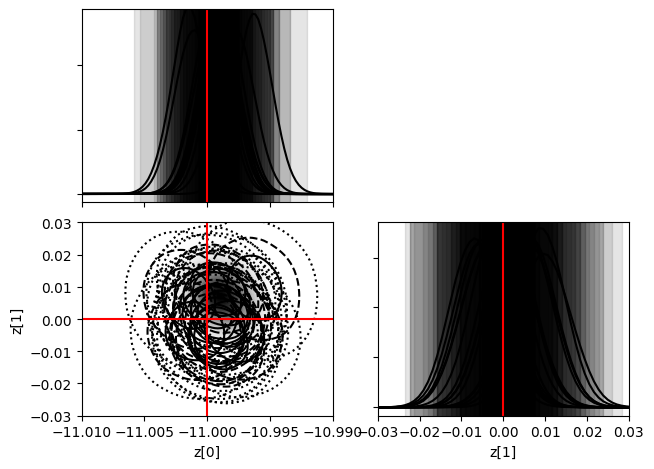

In [43]:
for idx, lr_file in enumerate(lr_result_files[::20]):
    logratios = pickle.load(open(lr_file, "rb"))
    if idx == 0: swyft.plot_corner(logratios, parnames=logratios.parnames[0], bins=1000, smooth=1.3)
    else: swyft.plot_corner(logratios, parnames=logratios.parnames[0], bins=1000, smooth=1.3, fig=plt.gcf())
lims = [[-11.01, -10.99], [-0.03, 0.03]]
truths = [-11.0, 0.0]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(truths[j], c="r")
ax = plt.subplot(2, 2, 3)
plt.axvline(truths[0], c="r")
plt.axhline(truths[1], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

In [7]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

def compute_stats(logratios):
    values_1 = logratios.params[:, 0, 0].numpy()
    values_2 = logratios.params[:, 0, 1].numpy()
    weights = np.exp(logratios.logratios[:, 0].numpy() - np.max(logratios.logratios[:, 0].numpy()))
    means = []
    stds = []
    mean, std1 = weighted_avg_and_std(values_1, weights)
    mean, std2 = weighted_avg_and_std(values_2, weights)
    means.append(mean)
    stds.append(std2)
    return std1, std2

In [8]:
from scipy.integrate import simps
from scipy.interpolate import interp1d
def get_sigmas(logratios):
    lrs = np.array(logratios.logratios[:, 0].reshape(int(np.sqrt(logratios.logratios.shape[0])), int(np.sqrt(logratios.logratios.shape[0]))))
    params_alpha = np.array(logratios.params[:, 0, 0].reshape(int(np.sqrt(logratios.params.shape[0])), int(np.sqrt(logratios.params.shape[0]))))
    params_gamma = np.array(logratios.params[:, 0, 1].reshape(int(np.sqrt(logratios.params.shape[0])), int(np.sqrt(logratios.params.shape[0]))))
    posterior = np.exp(lrs - np.max(lrs)) / np.sum(np.exp(lrs - np.max(lrs))) / (params_alpha[1, 0] - params_alpha[0, 0]) * (params_gamma[0, 1] - params_gamma[0, 0])
    alpha_marginal = simps(posterior, params_gamma, axis=1)
    gamma_marginal = simps(posterior, params_alpha, axis=0)
    alpha_ps = params_alpha[:, 0]
    gamma_ps = params_gamma[0, :]
    norm_alpha_marginal = alpha_marginal / simps(alpha_marginal, alpha_ps) 
    norm_gamma_marginal = gamma_marginal / simps(gamma_marginal, gamma_ps)
    alpha_cumulant =  np.cumsum(norm_alpha_marginal * (alpha_ps[1] - alpha_ps[0]))
    gamma_cumulant =  np.cumsum(norm_gamma_marginal * (gamma_ps[1] - gamma_ps[0]))
    alpha_interp = interp1d(alpha_cumulant, alpha_ps)
    gamma_interp = interp1d(gamma_cumulant, gamma_ps)
    alpha_sigma = 0.5 * (alpha_interp(0.5 + 0.34) - alpha_interp(0.5 - 0.34))
    gamma_sigma = 0.5 * (gamma_interp(0.5 + 0.34) - gamma_interp(0.5 - 0.34))
    return alpha_sigma, gamma_sigma
    

In [9]:
alpha_stds = []
gamma_stds = []
for idx, lr_file in enumerate(lr_result_files):
    logratios = pickle.load(open(lr_file, "rb"))
    #std1, std2 = compute_stats(logratios)
    std1, std2 = get_sigmas(logratios)
    alpha_stds.append(std1)
    gamma_stds.append(std2)
falpha_stds = []
fgamma_stds = []
for idx, lr_file in enumerate(flr_result_files):
    logratios = pickle.load(open(lr_file, "rb"))
    #std1, std2 = compute_stats(logratios)
    std1, std2 = get_sigmas(logratios)
    falpha_stds.append(std1)
    fgamma_stds.append(std2)


/tmp/ipykernel_1829064/1020906376.py:8: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  alpha_marginal = simps(posterior, params_gamma, axis=1)
/tmp/ipykernel_1829064/1020906376.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  gamma_marginal = simps(posterior, params_alpha, axis=0)
/tmp/ipykernel_1829064/1020906376.py:12: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  norm_alpha_marginal = alpha_marginal / simps(alpha_marginal, alpha_ps)
/tmp/ipykernel_1829064/1020906376.py:13: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  norm_gamma_marginal = gamma_marginal / simps(gamma_marginal, gamma_ps)


In [10]:
pickle.dump(alpha_stds, open("../results/full_inference/alpha_stds.pkl", "wb"))
pickle.dump(gamma_stds, open("../results/full_inference/gamma_stds.pkl", "wb"))
pickle.dump(falpha_stds, open("../results/full_inference/falpha_stds.pkl", "wb"))
pickle.dump(fgamma_stds, open("../results/full_inference/fgamma_stds.pkl", "wb"))

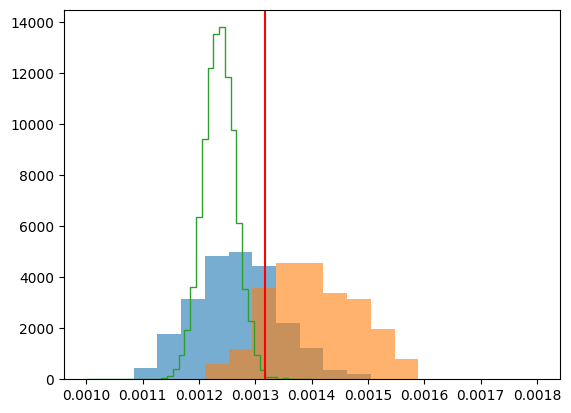

In [6]:
alpha_sensitivities = np.load('../results/alpha_sensivities.npy')
plt.hist(np.array(alpha_stds), bins=np.linspace(0.0010, 0.0018, 20), density=True, alpha=0.6)
plt.hist(np.array(falpha_stds), bins=np.linspace(0.0010, 0.0018, 20), density=True, alpha=0.6)
plt.hist(np.vstack([np.array(alpha_sensitivities) + 0.0 * np.random.normal(-0.0008397158735385796, 0.0005091857083170438, len(alpha_sensitivities)) for _ in range(200)]).reshape(-1), bins=np.linspace(0.0010, 0.0014, 40), density=True, histtype='step', alpha=1.0)
plt.axvline(0.00131719, c='r')

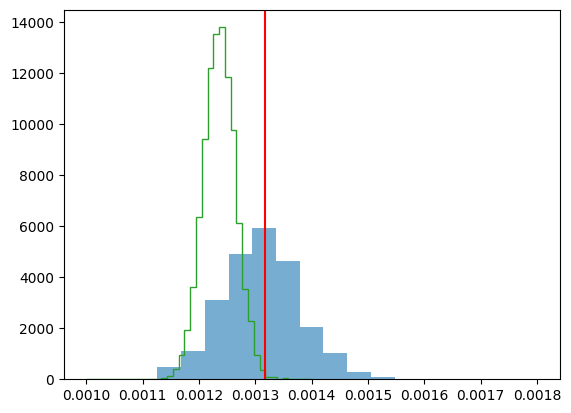

In [34]:
alpha_sensitivities = np.load('../results/alpha_sensivities.npy')
plt.hist(np.array(alpha_stds), bins=np.linspace(0.0010, 0.0018, 20), density=True, alpha=0.6)
plt.hist(np.array(falpha_stds), bins=np.linspace(0.0010, 0.0018, 20), density=True, alpha=0.6)
plt.hist(np.vstack([np.array(alpha_sensitivities) + 0.0 * np.random.normal(-0.0008397158735385796, 0.0005091857083170438, len(alpha_sensitivities)) for _ in range(200)]).reshape(-1), bins=np.linspace(0.0010, 0.0014, 40), density=True, histtype='step', alpha=1.0)
plt.axvline(0.00131719, c='r')

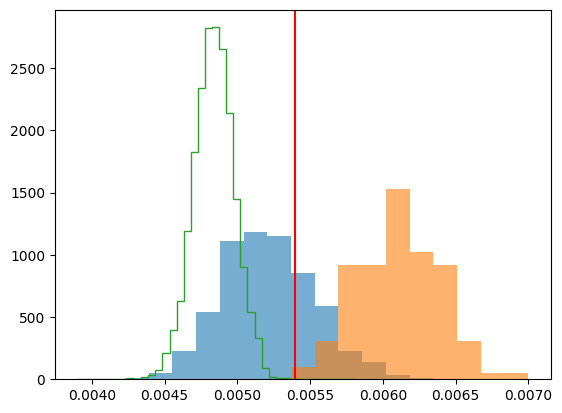

In [7]:
gamma_sensitivities = np.load('../results/beta_sensivities.npy')
plt.hist(np.array(gamma_stds), bins=np.linspace(0.00390, 0.007, 20), density=True, alpha=0.6)
plt.hist(np.array(fgamma_stds), bins=np.linspace(0.00390, 0.007, 20), density=True, alpha=0.6)
plt.hist(np.vstack([np.array(gamma_sensitivities) + 0.0 * np.random.normal(-0.0034697498204664936, 0.002485922162362506, len(gamma_sensitivities)) for _ in range(20)]).reshape(-1), bins=np.linspace(0.00390, 0.00580, 40), density=True, histtype='step', alpha=1.0)
plt.axvline(0.00539867, c='r')

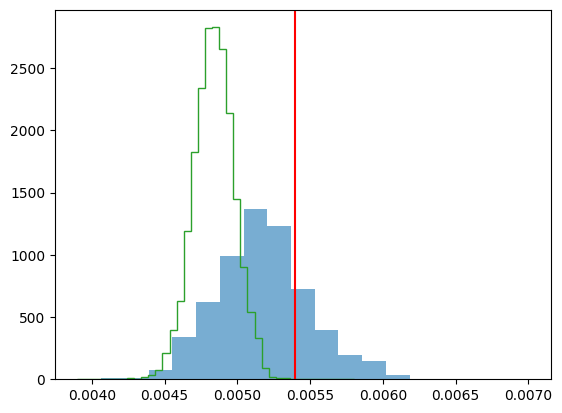

In [35]:
gamma_sensitivities = np.load('../results/beta_sensivities.npy')
plt.hist(np.array(gamma_stds), bins=np.linspace(0.00390, 0.007, 20), density=True, alpha=0.6)
plt.hist(np.array(fgamma_stds), bins=np.linspace(0.00390, 0.007, 20), density=True, alpha=0.6)
plt.hist(np.vstack([np.array(gamma_sensitivities) + 0.0 * np.random.normal(-0.0034697498204664936, 0.002485922162362506, len(gamma_sensitivities)) for _ in range(20)]).reshape(-1), bins=np.linspace(0.00390, 0.00580, 40), density=True, histtype='step', alpha=1.0)
plt.axvline(0.00539867, c='r')

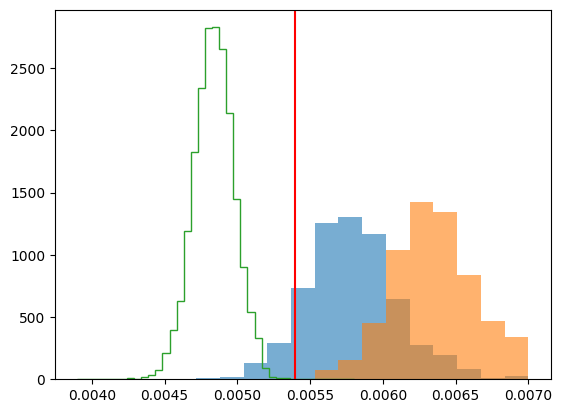

In [94]:
gamma_sensitivities = np.load('../results/beta_sensivities.npy')
plt.hist(np.array(gamma_stds), bins=np.linspace(0.00390, 0.007, 20), density=True, alpha=0.6)
plt.hist(np.array(fgamma_stds), bins=np.linspace(0.00390, 0.007, 20), density=True, alpha=0.6)
plt.hist(np.vstack([np.array(gamma_sensitivities) + 0.0 * np.random.normal(-0.0034697498204664936, 0.002485922162362506, len(gamma_sensitivities)) for _ in range(20)]).reshape(-1), bins=np.linspace(0.00390, 0.00580, 40), density=True, histtype='step', alpha=1.0)
plt.axvline(0.00539867, c='r')

In [118]:
from scipy.integrate import simps
from scipy.interpolate import interp1d
def get_sigmas(logratios):
    lrs = np.array(logratios.logratios[:, 0].reshape(int(np.sqrt(logratios.logratios.shape[0])), int(np.sqrt(logratios.logratios.shape[0]))))
    params_alpha = np.array(logratios.params[:, 0, 0].reshape(int(np.sqrt(logratios.params.shape[0])), int(np.sqrt(logratios.params.shape[0]))))
    params_gamma = np.array(logratios.params[:, 0, 1].reshape(int(np.sqrt(logratios.params.shape[0])), int(np.sqrt(logratios.params.shape[0]))))
    posterior = np.exp(lrs - np.max(lrs)) / np.sum(np.exp(lrs - np.max(lrs))) / (params_alpha[1, 0] - params_alpha[0, 0]) * (params_gamma[0, 1] - params_gamma[0, 0])
    alpha_marginal = simps(posterior, params_gamma, axis=1)
    gamma_marginal = simps(posterior, params_alpha, axis=0)
    alpha_ps = params_alpha[:, 0]
    gamma_ps = params_gamma[0, :]
    norm_alpha_marginal = alpha_marginal / simps(alpha_marginal, alpha_ps) 
    norm_gamma_marginal = gamma_marginal / simps(gamma_marginal, gamma_ps)
    alpha_cumulant =  np.cumsum(norm_alpha_marginal * (alpha_ps[1] - alpha_ps[0]))
    gamma_cumulant =  np.cumsum(norm_gamma_marginal * (gamma_ps[1] - gamma_ps[0]))
    print(alpha_cumulant)
    alpha_interp = interp1d(alpha_cumulant, alpha_ps)
    gamma_interp = interp1d(gamma_cumulant, gamma_ps)
    alpha_sigma = 0.5 * (alpha_interp(0.5 + 0.34) - alpha_interp(0.5 - 0.34))
    gamma_sigma = 0.5 * (gamma_interp(0.5 + 0.34) - gamma_interp(0.5 - 0.34))
    return alpha_sigma, gamma_sigma
    

In [168]:
compute_stats(logratios)

(0.0013428989, 0.005308869)

In [44]:
lrs = np.array(logratios.logratios[:, 0].reshape(int(np.sqrt(logratios.logratios.shape[0])), int(np.sqrt(logratios.logratios.shape[0]))))

In [50]:
params_alpha = np.array(logratios.params[:, 0, 0].reshape(int(np.sqrt(logratios.params.shape[0])), int(np.sqrt(logratios.params.shape[0]))))
params_gamma = np.array(logratios.params[:, 0, 1].reshape(int(np.sqrt(logratios.params.shape[0])), int(np.sqrt(logratios.params.shape[0]))))

(-0.015, 0.015)

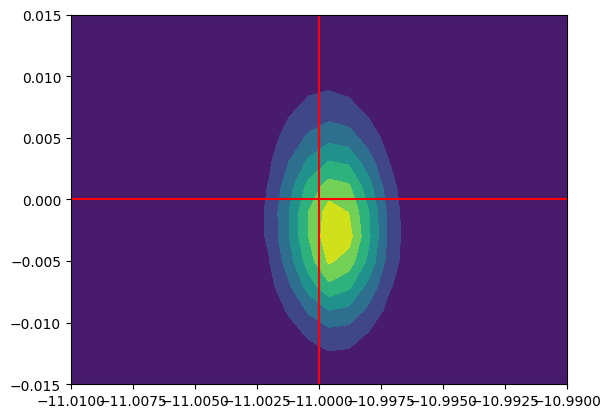

In [60]:
plt.contourf(params_alpha, params_gamma, np.exp(lrs - np.max(lrs)))
lims = [[-11.01, -10.99], [-0.015, 0.015]]
truths = [-11.0, 0.0]
plt.axvline(truths[0], c="r")
plt.axhline(truths[1], c="r")
plt.xlim(lims[0])
plt.ylim(lims[1])

In [70]:
posterior = np.exp(lrs - np.max(lrs)) / np.sum(np.exp(lrs - np.max(lrs))) / (lims[0][1] - lims[0][0]) / (lims[1][1] - lims[1][0])

In [80]:
from scipy.integrate import simps
alpha_marginal = simps(posterior, params_gamma, axis=1)
gamma_marginal = simps(posterior, params_alpha, axis=0)

/tmp/ipykernel_4071871/529976077.py:2: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  alpha_marginal = simps(posterior, params_gamma, axis=1)
/tmp/ipykernel_4071871/529976077.py:3: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  gamma_marginal = simps(posterior, params_alpha, axis=0)


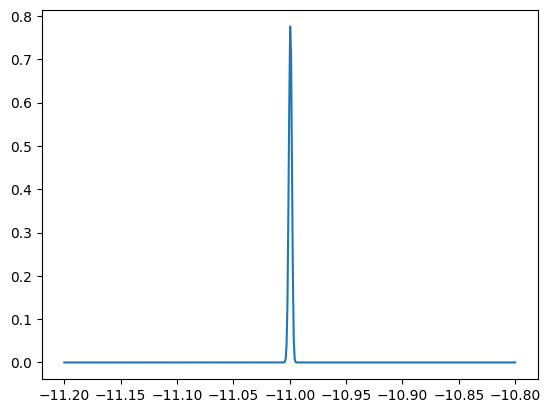

In [82]:
alpha_ps = params_alpha[:, 0]
gamma_ps = params_gamma[0, :]
plt.plot(alpha_ps, alpha_marginal)

In [76]:
simps(alpha_marginal, alpha_ps)

/tmp/ipykernel_4071871/2656637391.py:1: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  simps(alpha_marginal, alpha_ps)


0.0026717675810398103

/tmp/ipykernel_4071871/3614870698.py:17: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  plt.plot(alpha_ps, alpha_marginal / simps(alpha_marginal, alpha_ps))
/tmp/ipykernel_4071871/3614870698.py:19: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  plt.plot(gamma_ps, gamma_marginal / simps(gamma_marginal, gamma_ps))


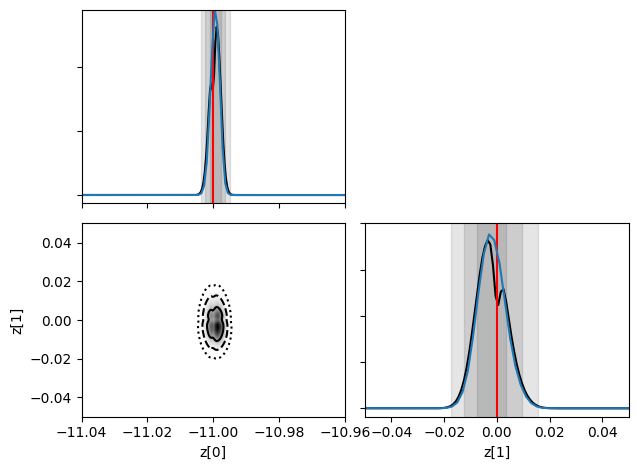

In [83]:
swyft.plot_corner(logratios, parnames=logratios.parnames[0], bins=1000, smooth=1.3)
lims = [[-11.04, -10.96], [-0.05, 0.05]]
truths = [-11.0, 0.0]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(truths[j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

ax = plt.subplot(2, 2, 1)
plt.plot(alpha_ps, alpha_marginal / simps(alpha_marginal, alpha_ps))
ax = plt.subplot(2, 2, 4)
plt.plot(gamma_ps, gamma_marginal / simps(gamma_marginal, gamma_ps))

/tmp/ipykernel_4071871/514199667.py:1: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  plt.plot(alpha_ps, np.cumsum(alpha_marginal / simps(alpha_marginal, alpha_ps) * (alpha_ps[1] - alpha_ps[0])))


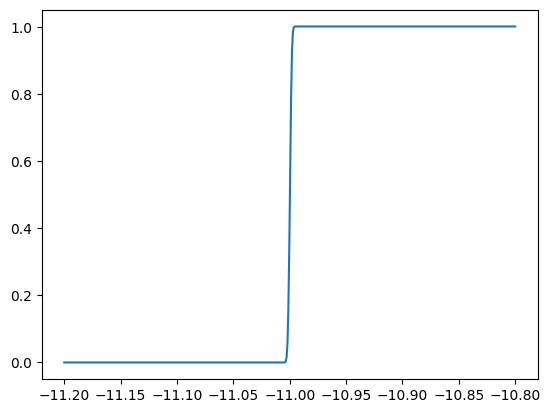

In [89]:
plt.plot(alpha_ps, np.cumsum(alpha_marginal / simps(alpha_marginal, alpha_ps) * (alpha_ps[1] - alpha_ps[0])))

In [91]:
cumulant =  np.cumsum(alpha_marginal / simps(alpha_marginal, alpha_ps) * (alpha_ps[1] - alpha_ps[0]))

/tmp/ipykernel_4071871/1950328487.py:1: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  cumulant =  np.cumsum(alpha_marginal / simps(alpha_marginal, alpha_ps) * (alpha_ps[1] - alpha_ps[0]))


In [94]:
alpha_min, alpha_max = alpha_ps[np.argwhere(cumulant >= (1 - 0.68) / 2)[0]], alpha_ps[np.argwhere(cumulant <= 1 - (1 - 0.68) / 2)[-1]]

-11.001203

In [96]:
(alpha_max - alpha_min) / 2

array([0.00120258], dtype=float32)

In [152]:
siga, sigg = get_sigmas(logratios)

/tmp/ipykernel_4071871/3275245888.py:8: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  alpha_marginal = simps(posterior, params_gamma, axis=1)
/tmp/ipykernel_4071871/3275245888.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  gamma_marginal = simps(posterior, params_alpha, axis=0)
/tmp/ipykernel_4071871/3275245888.py:12: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  norrm_alpha_marginal = alpha_marginal / simps(alpha_marginal, alpha_ps)
/tmp/ipykernel_4071871/3275245888.py:13: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  norrm_gamma_marginal = gamma_marginal / simps(gamma_marginal, gamma_ps)
/home/alveyjbg/mambaforge/envs/default/lib

ValueError: A value (0.84) in x_new is above the interpolation range's maximum value (4.015115543404256e-06).

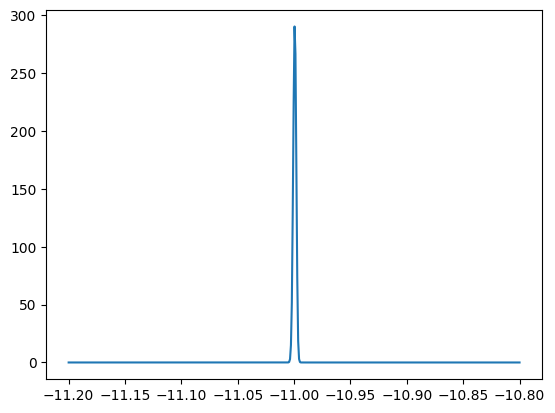

In [128]:
plt.plot(alpha_ps, nam)

In [131]:
mu = simps(nam * alpha_ps, alpha_ps)
sig = np.sqrt(simps(nam * (alpha_ps - mu)**2, alpha_ps))

/tmp/ipykernel_4071871/4121916570.py:1: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  mu = simps(nam * alpha_ps, alpha_ps)
/tmp/ipykernel_4071871/4121916570.py:2: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  sig = np.sqrt(simps(nam * (alpha_ps - mu)**2, alpha_ps))


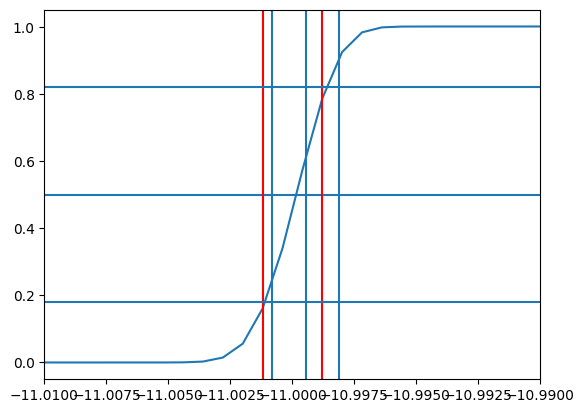

In [144]:
plt.plot(alpha_ps, np.cumsum(nam * (alpha_ps[1] - alpha_ps[0])))
plt.xlim([-11.01, -10.99])
plt.axhline(0.5)
plt.axvline(mu)
plt.axvline(mu - sig)
plt.axvline(mu + sig)
plt.axvline(alpha_min, c='r')
plt.axvline(alpha_max, c='r')
plt.axhline(0.5 + 0.32)
plt.axhline(0.5 - 0.32)

In [145]:
from scipy.interpolate import interp1d
f = interp1d(np.cumsum(nam * (alpha_ps[1] - alpha_ps[0])), alpha_ps)

In [150]:
(f(0.5 + 0.32) - f(0.5 - 0.32)) / 2

0.0012568919615612018